# CART & RF——Otto商品分类

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用缺省参数CART、CART + GridSearchCV 以及Random Forest + GridSearchCV进行参数调优。

同时考虑通过feature_importances_进行特征选择

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


In [44]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss 
from sklearn import metrics  

from matplotlib import pyplot 
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索

In [45]:
# 读取数据
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

In [46]:
#train.info()

In [47]:
## 各属性的统计特性
#train.describe()

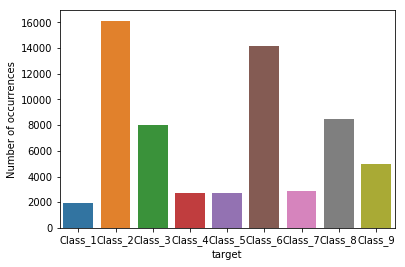

In [48]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样

## 特征编码

In [49]:
# 将类别字符串变成数字
# drop ids and get labels
y_train = train['target']   #形式为Class_x
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
columns = train.columns

X_train = np.array(train)

#如果计算资源有限，也可只取少量样本，如取前1000个样本
#（分类中其实还需要确保取出来的这部分样本各类样本的比例和总体一致）
#n_trains = 1000
#y_train = train.label.values[:n_trains]

## 数据预处理

In [50]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
#X_test = ss_X.transform(X_test)


/usr/local/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 模型训练

### default Desion Tree (CART)

In [51]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier()

model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(model_tree, X_train, y_train, cv=10, scoring='neg_log_loss')
print('logloss of each fold is: ',-loss)
print('cv logloss is:', -loss.mean())

logloss of each fold is:  [10.22441491  9.95828071  9.69206052  9.93199063  9.92403756  9.93841287
  9.56990992  9.69832761  9.55315978  9.78682456]
cv logloss is: 9.827741905692836


In [53]:
# 看看特征重要性
df = pd.DataFrame({"columns":list(columns), "importance":list(model_tree.feature_importances_.T)})
df.sort_values(by=['importance'],ascending=False)

,columns,importance
10,feat_11,0.101488
59,feat_60,0.080703
33,feat_34,0.051536
89,feat_90,0.045836
13,feat_14,0.040731
14,feat_15,0.037724
38,feat_39,0.024783
35,feat_36,0.024519
85,feat_86,0.023717
41,feat_42,0.021990


## 决策树参数调优

决策树的超参数有：max_depth（树的深度）或max_leaf_nodes（叶子结点的数目）、max_features（最大特征数目）、min_samples_leaf（叶子结点的最小样本数）、min_samples_split（中间结点的最小样本树）、min_weight_fraction_leaf（叶子节点的样本权重占总权重的比例）
min_impurity_split（最小不纯净度）也可以调整

这里调整max_depth试试

In [54]:
from sklearn.tree import DecisionTreeClassifier

model_DD = DecisionTreeClassifier()

#设置参数搜索grid
max_depth = range(5,15,1)
#min_samples_leaf = range(1,10,2)
tuned_parameters = dict(max_depth=max_depth)

In [55]:
#GridSearchCV
from sklearn.model_selection import GridSearchCV
DD = GridSearchCV(model_DD, tuned_parameters, scoring='neg_log_loss', cv=10)
DD.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [56]:
print("Best: %f using %s" % (-DD.best_score_, DD.best_params_)) 

Best: 1.152841 using {'max_depth': 10}


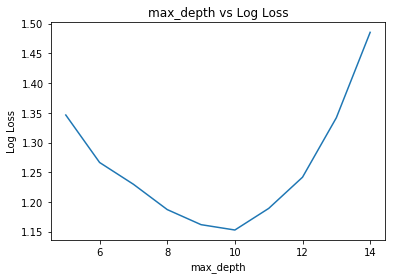

In [57]:
test_means = -DD.cv_results_[ 'mean_test_score' ]

x_axis = range(5, test_means.shape[0]+5)
        
pyplot.plot(x_axis, test_means)
pyplot.title("max_depth vs Log Loss")
pyplot.xlabel( 'max_depth' )
pyplot.ylabel( 'Log Loss' )

pyplot.show()

In [58]:
# 看看特征重要性
df = pd.DataFrame({"columns":list(columns), "importance":list(DD.best_estimator_.feature_importances_.T)})
df.sort_values(by=['importance'],ascending=False)

,columns,importance
10,feat_11,0.207353
59,feat_60,0.161913
33,feat_34,0.096588
89,feat_90,0.094994
13,feat_14,0.064526
14,feat_15,0.059559
35,feat_36,0.040157
38,feat_39,0.033849
29,feat_30,0.030796
41,feat_42,0.023899


## 做下特征选择看看

In [59]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(DD.best_estimator_, prefit=True)
X_Train_new = model.transform(X_train)
X_Train_new.shape               

(61878, 15)

## 用选择的特征，CV选择的max_depth参数，再次训练模型

In [60]:
model_tuned_tree = DecisionTreeClassifier(max_depth= DD.best_params_['max_depth'])

#model_tuned_tree.fit(X_Train_new, y_train)
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(model_tuned_tree, X_Train_new, y_train, cv=10, scoring='neg_log_loss')
print('logloss of each fold is: ',-loss)
print('cv logloss is:', -loss.mean())

logloss of each fold is:  [1.11137057 1.1940186  1.19205101 1.19959388 1.21424224 1.19544046
 1.20219343 1.14886683 1.17956698 1.11508118]
cv logloss is: 1.175242518096979


这比用全部特征得到的1.148384大了好多，特征剔除得太多了

In [61]:
# 少剔除一些看看
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(DD.best_estimator_, threshold = 0.000042, prefit=True)
X_Train_new = model.transform(X_train)
X_Train_new.shape               

(61878, 77)

In [62]:
model_tuned_tree = DecisionTreeClassifier(max_depth= DD.best_params_['max_depth'])

#model_tuned_tree.fit(X_Train_new, y_train)
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(model_tuned_tree, X_Train_new, y_train, cv=10, scoring='neg_log_loss')
print ('logloss of each fold is: ',-loss)
print('cv logloss is:', -loss.mean())

logloss of each fold is:  [1.09796264 1.16614614 1.16236813 1.18083534 1.17263245 1.13404435
 1.19080573 1.11005165 1.1369748  1.11565652]
cv logloss is: 1.1467477759939162


结果好像好了一丢丢，特征少点更好。。。

### 还是写一个自动监控程序看看

决策树运行快，所以在这示意监控过程。Random Forest部分大家可以参照写一个，不过得对训练时间有足够的心理准备。

In [63]:
import time
# 一个threshold对应的特征选择，及相应的模型训练和测试，得到该参数下模型在校验集上的预测性能
def one_feature_selection(threshold, X_train, y_train):
    start = time.time()
    
    print("threshold: {}".format(threshold))
    model = SelectFromModel(DD.best_estimator_, threshold = threshold, prefit=True)
    X_Train_new = model.transform(X_train)
    print(X_Train_new.shape)   

    # 在训练集和测试集降维 
    DD.best_estimator_.get_params()
    model_tuned_tree = DecisionTreeClassifier(max_depth = DD.best_estimator_.get_params()['max_depth'] )

    loss = cross_val_score(model_tuned_tree, X_Train_new, y_train, cv=10, scoring='neg_log_loss')
    cvloss = -loss.mean()
    
    end = time.time()
    print("cvloss: {}".format(cvloss.mean()))
    return cvloss

In [64]:
# 设置threshold搜索范围
# 每次去掉最不重要的5%
cols = df.shape[0] #总的特征数目
step = int(cols*0.05)

threshold_s = np.zeros(20)
losses = []
for i in range(1,20,1):
    threshold_s[i-1] = df.importance[cols - i*step]
    #排序好像不起作用，取不到特征阈值，再好好看看。。。
    tmp = one_feature_selection(threshold_s[i-1],  X_train, y_train)
    losses.append(tmp)

threshold: 0.09499385807114194
(61878, 4)
cvloss: 1.516422573122862
threshold: 0.020651033312055474
(61878, 11)
cvloss: 1.213970900708919
threshold: 7.958243162528716e-05
(61878, 74)
cvloss: 1.1471316214349119
threshold: 0.0025599216128586364
(61878, 29)
cvloss: 1.1680918599376502
threshold: 0.0004274979409779415
(61878, 53)
cvloss: 1.146981861763632
threshold: 0.0011449379882482505
(61878, 38)
cvloss: 1.1614234505597303
threshold: 0.0001674885359460762
(61878, 65)
cvloss: 1.1451524504518837
threshold: 0.012246832435062312
(61878, 15)
cvloss: 1.173597574295417
threshold: 0.00015522661033167589
(61878, 66)
cvloss: 1.1462801691388456
threshold: 0.0007161483401173315
(61878, 46)
cvloss: 1.1508438206486926
threshold: 0.0009176478728178978
(61878, 40)
cvloss: 1.1545307417961816
threshold: 0.0
(61878, 93)
cvloss: 1.1532329385548201
threshold: 0.023898571454404573
(61878, 10)
cvloss: 1.204637920529874
threshold: 0.0
(61878, 93)
cvloss: 1.1538022872113516
threshold: 0.09658812612060114
(61878,

# Random Forest

随机森林可调整的超参数（除了和决策树相同的参数）：n_estimators（弱学习器的数目）
所以下面一起调整树的max_depth和n_estimators

In [65]:
from sklearn.ensemble import RandomForestClassifier

model_RR=RandomForestClassifier()

#设置参数搜索grid
max_depth = range(10,30,2)
n_estimators = range(10,20,2)
tuned_parameters = dict(max_depth=max_depth, n_estimators = n_estimators)

In [66]:
from sklearn.model_selection import GridSearchCV
RR = GridSearchCV(model_RR, tuned_parameters, scoring='neg_log_loss', cv=10)
RR.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(10, 30, 2), 'n_estimators': range(10, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [67]:
print("Best: %f using %s" % (-RR.best_score_, RR.best_params_)) 

Best: 0.662158 using {'max_depth': 24, 'n_estimators': 18}


性能比一棵树好多了，还是森林好！

In [68]:
RR.grid_scores_

/usr/local/python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.97644, std: 0.01096, params: {'max_depth': 10, 'n_estimators': 10},
 mean: -0.97493, std: 0.00912, params: {'max_depth': 10, 'n_estimators': 12},
 mean: -0.97008, std: 0.00854, params: {'max_depth': 10, 'n_estimators': 14},
 mean: -0.96445, std: 0.00835, params: {'max_depth': 10, 'n_estimators': 16},
 mean: -0.96782, std: 0.00299, params: {'max_depth': 10, 'n_estimators': 18},
 mean: -0.89282, std: 0.01621, params: {'max_depth': 12, 'n_estimators': 10},
 mean: -0.88700, std: 0.00882, params: {'max_depth': 12, 'n_estimators': 12},
 mean: -0.88315, std: 0.00909, params: {'max_depth': 12, 'n_estimators': 14},
 mean: -0.88079, std: 0.00756, params: {'max_depth': 12, 'n_estimators': 16},
 mean: -0.87959, std: 0.01031, params: {'max_depth': 12, 'n_estimators': 18},
 mean: -0.82184, std: 0.01173, params: {'max_depth': 14, 'n_estimators': 10},
 mean: -0.81726, std: 0.00698, params: {'max_depth': 14, 'n_estimators': 12},
 mean: -0.81283, std: 0.01223, params: {'max_depth': 14, 'n_esti

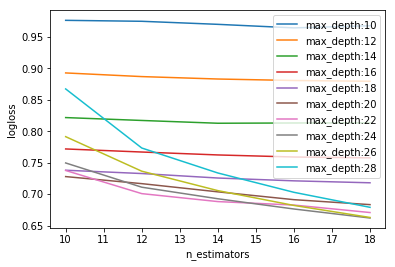

In [69]:
test_means = -RR.cv_results_[ 'mean_test_score' ]

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(n_estimators))
x_axis = n_estimators
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, test_scores[i], label= 'max_depth:'   + str(value))

pyplot.legend()
pyplot.xlabel( 'n_estimators' )                                                                                                      
pyplot.ylabel( 'logloss' )
pyplot.show()

最佳的n_estimators在我们参数搜索范围的边界，我们还需要进一步扩大n_estimators的搜索范围，继续寻找
并且max_depth在20以前是下降明显（不管对多少的n_estimators）

GBDT是递归，所以树的深度不要太大，n_estimators可以多
随机森林还是需要每棵树深一些

In [70]:
from sklearn.ensemble import RandomForestClassifier

model_RR=RandomForestClassifier()

#设置参数搜索grid
max_depth = range(20,30,2)
n_estimators = range(20,100,10)
tuned_parameters = dict(max_depth=max_depth, n_estimators = n_estimators)

可以先去睡觉...
随着树的深度和数目的增加，训练时间越来越长
可以考虑不用交叉验证，而是train_test_split(尤其是计算资源不够的情况下，之前给过SVM核参数调优的时候给个示例代码，大家可以参考)

In [71]:
from sklearn.model_selection import GridSearchCV
RR = GridSearchCV(model_RR, tuned_parameters, scoring='neg_log_loss', cv=10)
RR.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(20, 30, 2), 'n_estimators': range(20, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [72]:
print("Best: %f using %s" % (-RR.best_score_, RR.best_params_)) 

Best: 0.595678 using {'max_depth': 28, 'n_estimators': 90}


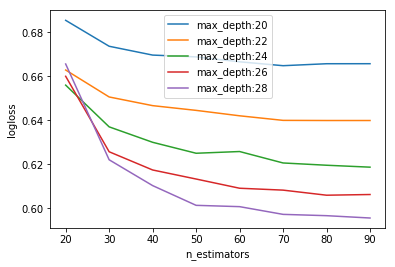

In [73]:
test_means = -RR.cv_results_[ 'mean_test_score' ]

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(n_estimators))
x_axis = n_estimators
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, test_scores[i], label= 'max_depth:'   + str(value))

pyplot.legend()
pyplot.xlabel( 'n_estimators' )                                                                                                      
pyplot.ylabel( 'logloss' )
pyplot.show()

看来模型还是太简单，大家请继续调整参数，继续增加模型复杂度。。。

## 请自行补充根据特征重要性选择特征
可以设置threshold的搜索范围，然后用CV监控模型性能，从而确定合适的特征数目

# 生产测试结果
假设模型已经训练好了，利用训练好的模型在测试样本上机械能测试，

In [74]:
# Create submission
test = pd.read_csv(dpath +"Otto_test.csv")

#准备好测试数据
ids = test["id"]
test = train.drop(["id"], axis=1)

#数据预处理
X_test = np.array(test)
X_test = ss_X.transform(X_test)

#测试
y_pred = RR.predict_proba(X_test)

submission = pd.DataFrame({ "id": ids})

i = 0
# Create column name based on target values(see sample_submission.csv)
for num in range_of_classes:
    col_name = str("Class_{}".format(num))
    submission[col_name] = y_pred[:,i]
    i = i + 1
    
submission.to_csv('test_Result_otto.csv', index=False)

FileNotFoundError: [Errno 2] File b'../data/Otto_test.csv' does not exist: b'../data/Otto_test.csv'